# Building a Handbags-Shoes Classifier with Transfer Learning

* Based on [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python-second-edition?gclid=CjwKCAjw9aiIBhA1EiwAJ_GTSlKgxc4qopKHPsFWryOoTz7fvhvhzYSjEsgQ-bG1R51QSGppISywpBoClcIQAvD_BwE) by Francois Chollett

## Introduction

In this Colab, we wil first build a **convolutional neural network** from scratch. 

We will then describe a very powerful technique called **Transfer Learning** that can be used to build highly accurate image classification models even when you have very little data. Pretty much any consumer-facing app that uses image AI was probably built using this technique.

We also show how to use a technique called **data augmentation** to effortlessly increase the size of your training dataset, and thereby achieve better accuracy.

---


---

But, as usual, let's get the usual technical preliminaries out of the way first.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the 
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

Unlike the earlier colab where we used a dataset that comes packaged with Keras, in this colab we will work with our own data.

I have web-scraped approximately 100 color images each of handbags and shoes, packaged it up as a zip file and placed it in Dropbox.

The code below downloads this zip file and unzips it so that colab can access it.

In [2]:
!wget -q -P ./ https://www.dropbox.com/s/w07liww46kgxo1m/handbags-shoes.zip
!unzip -qq handbags-shoes.zip

## Data Pre-processing



Is "Deep Learning" even possible with so few examples? (for comparison: Fashion MNIST had **60,000** training examples).

YES!

We will now build a near-perfect handbags vs shoes classifier using **just** these 200 images!





---



---

Since this isn't a standard Keras dataset, we will need to split it into train/validation/test sets ourselves.    

In [3]:
import os, shutil, pathlib

base_dir = pathlib.Path("/content/handbags-shoes")


In [4]:
#!rm -rf /content/handbags-shoes 

In [5]:
for category in ('handbags', 'shoes'):
  fnames = os.listdir(base_dir/category)
  dir = base_dir /'train' / category
  os.makedirs(dir)
  for fname in fnames[:50]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)
  dir = base_dir /'validation' / category
  os.makedirs(dir)
  for fname in fnames[50:75]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)
  dir = base_dir /'test' / category
  os.makedirs(dir)
  for fname in fnames[75:]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

The code above creates this directory structure:

handbags_vs_shoes/  
...train/   
......handbags/         
......shoes/    
...validation/    
......handbags/       
......shoes/         
...test/    
......handbags/     
......shoes/   




---



---




When working with image JPEGs, we will follow this process:

1.   Read in the JPEGs
2.   Convert the JPEGs into tensors 
3.   Resize them to a standard size (since web-scraped images may be in different sizes)
5.   Group them into batches (we’ll use batches of 32 images).


Fortunately, Keras gives us a single function that does all these in one shot! (Ref: [image manipulation functions](https://keras.io/api/preprocessing/image/))


In [6]:
train_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'train',
    image_size=(224, 224),
    batch_size=32)

validation_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'validation',
    image_size=(224, 224),
    batch_size=32)

test_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'test',
    image_size=(224, 224),
    batch_size=32)


Found 95 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


**Less than 100 examples in the training set!!** 



Let's check the shape of each image. Since these are color images, they will have 3 channels and since we sized them to (224, 224) 👆, the shape should be (224, 224, 3).

In [7]:
for images, _ in train_dataset.take(1):
  print(images[0].shape)

(224, 224, 3)


Check!

Let's look at a few examples.

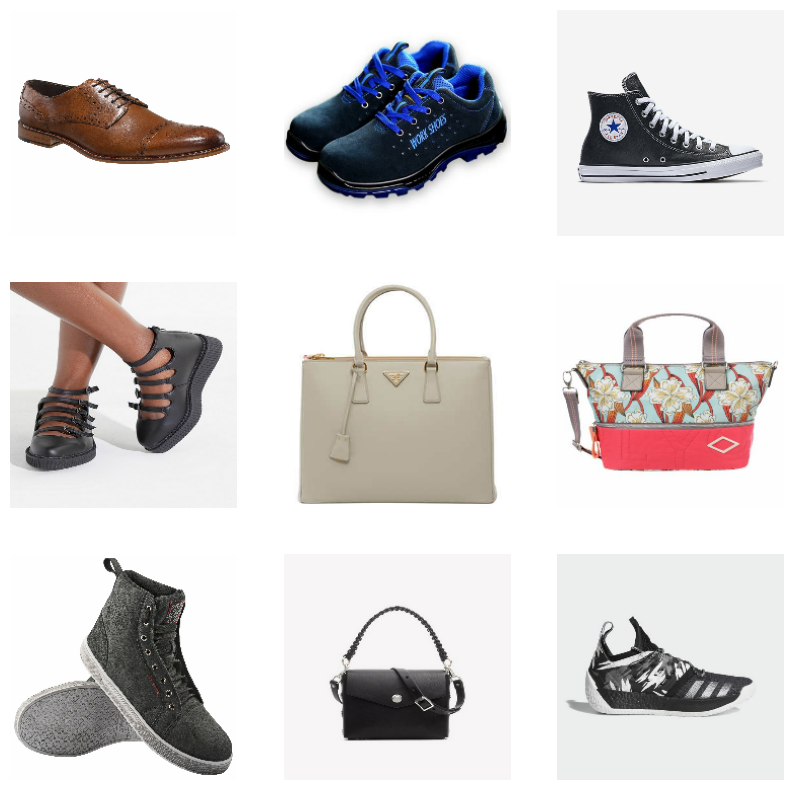

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## A Basic Convolutional Neural Network



---



---



We will try a simple CNN on this dataset with two convolutional blocks.

In [9]:
input = keras.Input(shape=(224,224,3))

# we normalize "inside" the model with a Rescaling layer
# so that we don't have to remember to do it every time
# we need to use the model to make a prediction
h = keras.layers.Rescaling(1./255)(input)


# first convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu", 
                        name="Conv_1")(h) 
h = keras.layers.MaxPool2D()(h) 


# second convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu", 
                        name="Conv_2")(h) 
h = keras.layers.MaxPool2D()(h) 

# flatten layer
h = keras.layers.Flatten()(h)   

# output layer
output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 Conv_2 (Conv2D)             (None, 110, 110, 32)      4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                         

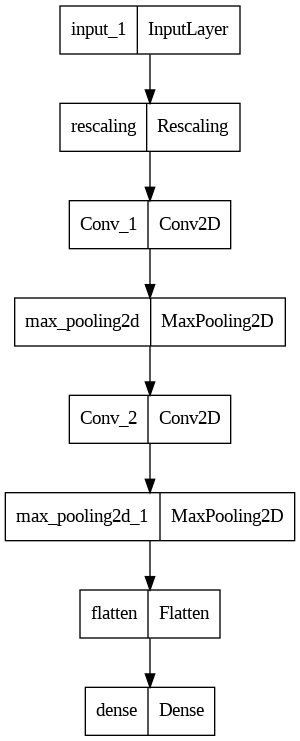

In [11]:
keras.utils.plot_model(model)

In [12]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Note that we chose the `binary_cross_entropy` loss function above since this is just a **binary** classification problem (e.g., handbags or shoes).

As usual, we will tell Keras to track loss and accuracy on the **validation** set so we can keep an eye on any overfitting.

We will also store the results of running `model.fit` in the variable `history`. This will allow us to plot how the loss and accuracy changed from epoch to epoch etc. and thereby get a sense for any overfitting.

In [13]:
history = model.fit(train_dataset, 
                    epochs=20,
                    validation_data=validation_dataset)

Epoch 1/20
3/3 [==============================] - 13s 506ms/step - loss: 1.9771 - accuracy: 0.4105 - val_loss: 0.6834 - val_accuracy: 0.5000
Epoch 2/20
3/3 [==============================] - 1s 178ms/step - loss: 1.0577 - accuracy: 0.5053 - val_loss: 1.0411 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 1s 177ms/step - loss: 0.7364 - accuracy: 0.6211 - val_loss: 0.6132 - val_accuracy: 0.5800
Epoch 4/20
3/3 [==============================] - 1s 178ms/step - loss: 0.6304 - accuracy: 0.5368 - val_loss: 0.6999 - val_accuracy: 0.5000
Epoch 5/20
3/3 [==============================] - 1s 178ms/step - loss: 0.5667 - accuracy: 0.6211 - val_loss: 0.5144 - val_accuracy: 0.8600
Epoch 6/20
3/3 [==============================] - 1s 176ms/step - loss: 0.4323 - accuracy: 0.9158 - val_loss: 0.4968 - val_accuracy: 0.7800
Epoch 7/20
3/3 [==============================] - 1s 169ms/step - loss: 0.3750 - accuracy: 0.9368 - val_loss: 0.4287 - val_accuracy: 0.9000
Epoch 8/20
3/3 [===

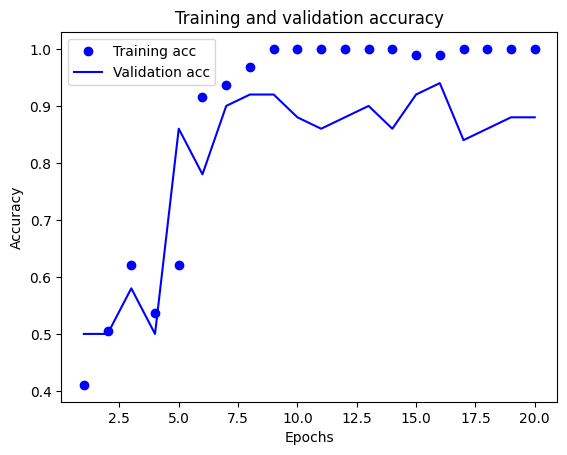

In [16]:
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [15]:
plot_acc_curves(history)

NameError: ignored

The model achieves a high training accuracy. This is not surprising, since our training dataset has only ~90 examples while our model has 101,345 parameters!

The validation accuracy curve is very noisy because the validation dataset is only 49 examples but it is clear there's a gap between training and validation accuracy curves, suggesting **overfitting**. 




Let's check the accuracy on the test set.

In [17]:
model.evaluate(test_dataset)

2/2 [==============================] - 0s 113ms/step - loss: 0.7272 - accuracy: 0.7750


[0.7272340059280396, 0.7749999761581421]

OK, what can we do to improve accuracy?

We can go back and scrape more data, of course, but that is a lot of work.

What else?

## Data Augmentation for Images

The basic idea of augmentation is to slightly alter the image so that the value of the dependent variable (i.e. the category that it belongs to) doesn't change. For instance, if you rotate the image of a handbag by 10 degrees or zoom in on it slightly, the content of the image doesn't change; it is *still* a handbag.

By applying these transformations repeatedly to an image, you can create new images and thereby increase the size of the dataset almost effortlessly.

Researchers have developed a list of these transformations that you can apply to images and Keras provides them out of the box as different kinds of *layers*.



---



---



To demonstrate, here's a little Keras model that applies three transformations to an incoming image.

We will use the Keras Sequential API since that's the easiest way to do this.

In [18]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)

Let's apply it to an image from our training set to see what it produces.

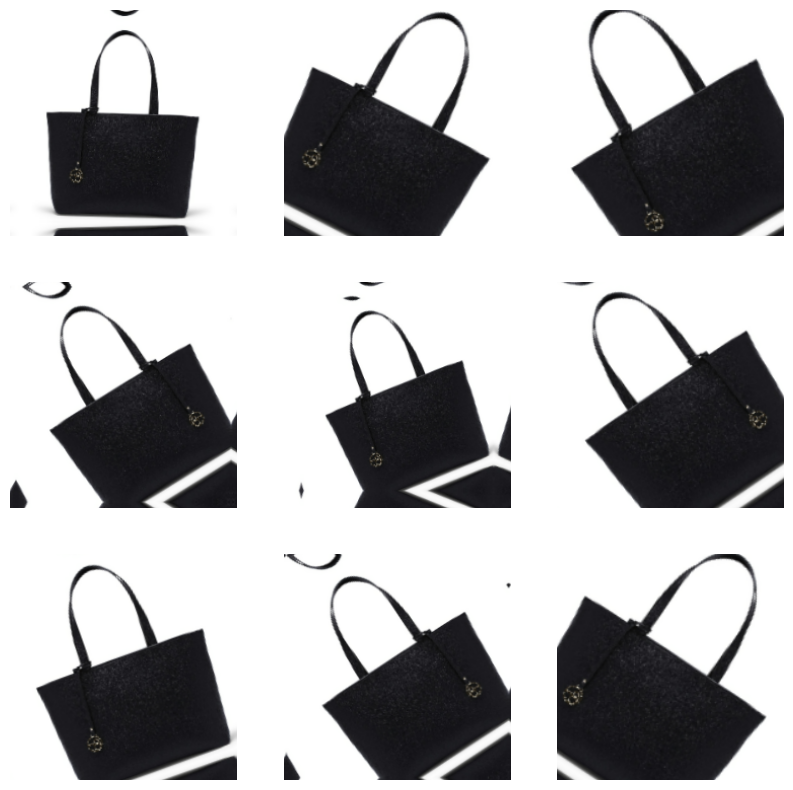

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

We can add `data_augmentation` right after the input layer in the convolutional NN model we built earlier, and train the model as before. Because we have effectively more data now, we can train this data-augmented model for more epochs at a lower risk of overfitting.

In [21]:
input = keras.Input(shape=(224,224,3))

# we have inserted the data augmentation layer here
h = data_augmentation(input)
# rest of the model is the same as before


h = keras.layers.Rescaling(1./255)(input)


# first convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu", 
                        name="Conv_1")(h) 
h = keras.layers.MaxPool2D()(h) 


# second convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu", 
                        name="Conv_2")(h) 
h = keras.layers.MaxPool2D()(h) 

# flatten layer
h = keras.layers.Flatten()(h)   

# output layer
output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

In the interest of time, we won't train this model. We encourage you to do so and evaluate if the data augmentation improves the accuracy on the test set.

## Model built with Transfer Learning


**SWITCH TO PPT FOR TRANSFER LEARNING**




---

We will work with ResNet-50 (rather than ResNet-34 as shown in the picture below) since it comes pre-packaged with Keras. 

Check out all the pre-trained models available in [Keras](https://keras.io/api/applications/) and in [Tensorflow](https://www.tensorflow.org/hub).



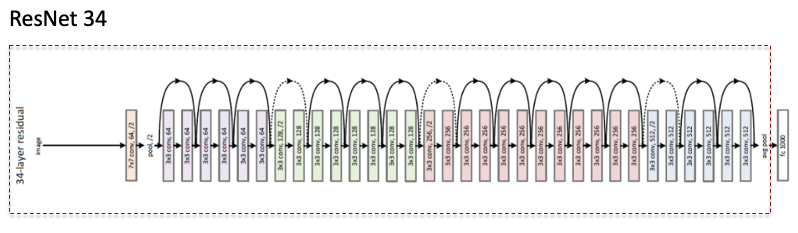

In [22]:
resnet50_base = keras.applications.ResNet50(
  weights='imagenet',
  include_top=False,
  input_shape=(224, 224, 3))

In [23]:
resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

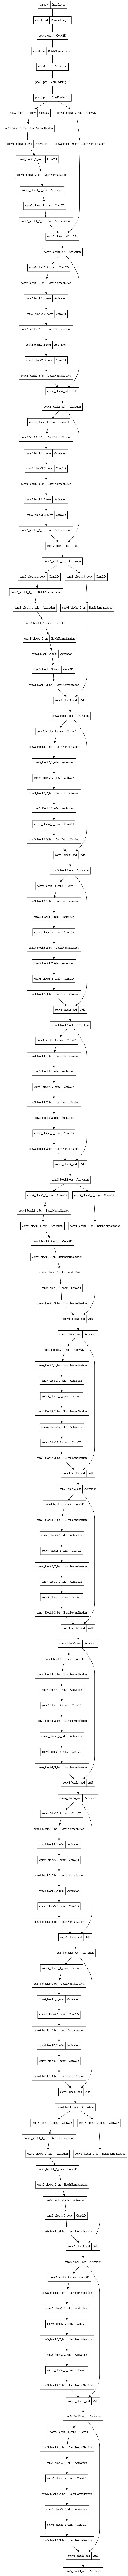

In [24]:
keras.utils.plot_model(resnet50_base)

It is a **DEEP** network, all right!!

Next, we run our dataset through "headless ResNet" to get the transformed, "smart" inputs.


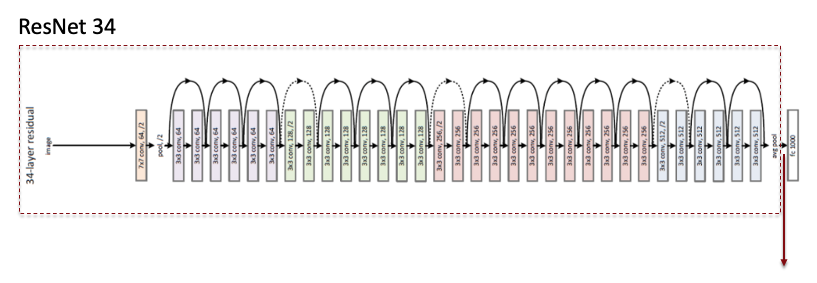

In [25]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.resnet50.preprocess_input(images)
    features = resnet50_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

In [26]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 517ms/step


What's the shape of the tensor that comes out of 'headless' ResNet?

In [27]:
train_features.shape

(95, 7, 7, 2048)

These tensors coming out of "headless" ResNet are smart representations and we can simply attach them to a small NN.  

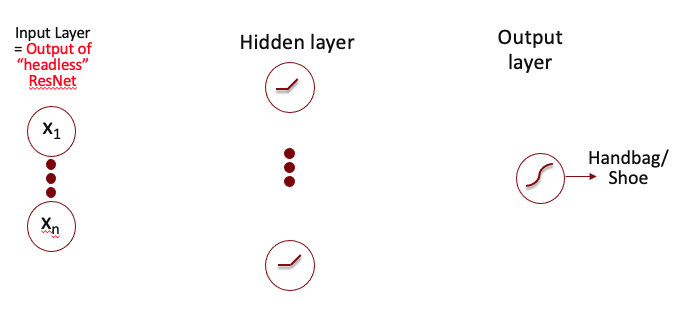


We will use a regularization layer that we haven't yet used: `Dropout`. 

In [28]:
input = keras.Input(shape=(7, 7, 2048))

h = keras.layers.Flatten()(input)

h = keras.layers.Dense(256, activation="relu")(h)

h = keras.layers.Dropout(0.5)(h) # first time we are using this!

output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

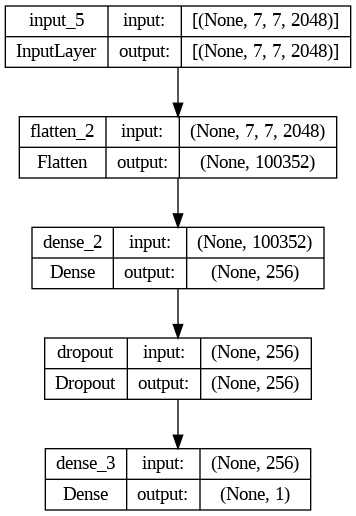

In [29]:
keras.utils.plot_model(model, show_shapes=True)

In [30]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 25,690,625
Trainable params: 25,690,625
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_features, 
                    train_labels,
                    epochs=10,
                    validation_data=(val_features, val_labels))

Epoch 1/10
3/3 [==============================] - 2s 159ms/step - loss: 3.4398 - accuracy: 0.7474 - val_loss: 0.4666 - val_accuracy: 0.9800
Epoch 2/10
3/3 [==============================] - 0s 43ms/step - loss: 1.3675 - accuracy: 0.9684 - val_loss: 4.0736 - val_accuracy: 0.9000
Epoch 3/10
3/3 [==============================] - 0s 52ms/step - loss: 7.0689e-15 - accuracy: 1.0000 - val_loss: 1.2478 - val_accuracy: 0.9800
Epoch 4/10
3/3 [==============================] - 0s 64ms/step - loss: 3.9345e-10 - accuracy: 1.0000 - val_loss: 0.7220 - val_accuracy: 0.9800
Epoch 5/10
3/3 [==============================] - 0s 47ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.3467 - val_accuracy: 0.9800
Epoch 6/10
3/3 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9800
Epoch 7/10
3/3 [==============================] - 0s 34ms/step - loss: 3.7953e-38 - accuracy: 1.0000 - val_loss: 8.6354e-06 - val_accuracy: 1.0000
Ep

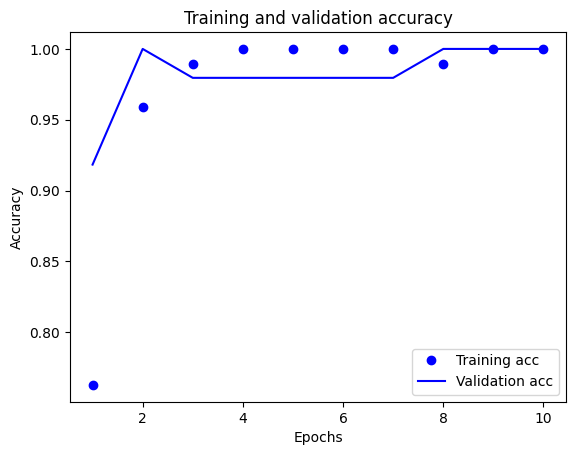

In [ ]:
plot_acc_curves(history)

The training and validation accuracies are both very high! This looks promising!

In [32]:
model.evaluate(test_features, test_labels)

2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

**IMPRESSIVE ACCURACY ON THE TEST SET!!**


Let's pause for a moment to reflect on what we have done.

We have built an amazingly accurate handbags or shoes classifier with *just* 100 training images!

That's the power of transfer learning!!

OK, let's test it **LIVE** with my laptop's webcam.

In [33]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename



In [34]:
def predict_image(im):
  img = keras.preprocessing.image.load_img(im, target_size=(224,224))
  arr = keras.preprocessing.image.img_to_array(img)
  arr = keras.applications.resnet50.preprocess_input(arr)
  arr = np.expand_dims(arr, axis=0)
  arr = resnet50_base(arr)
  pred = model.predict(arr)
  pred = "SHOE" if pred > 0.5 else "HANDBAG"
  print("************************************\n\n")
  print(f"...........it is a {pred}!")
  print("\n\n************************************\n\n")

<IPython.core.display.Javascript object>

Saved to photo.jpg


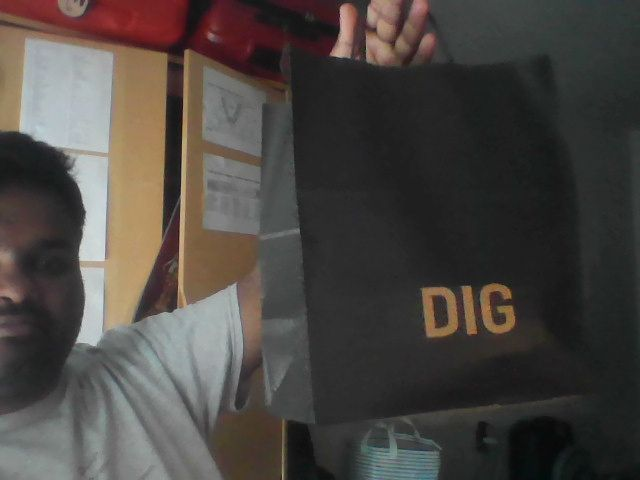

1/1 [==============================] - 0s 55ms/step
************************************


...........it is a HANDBAG!


************************************




In [35]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
  predict_image(filename)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

**THE END**